# Monte Carlo simulation

Please cite: V. C. Chmielewski and E. C. Bruning (2016), Lightning Mapping Array flash detection performance with variable receiver thresholds, J. Geophys. Res. Atmos., 121, 8600-8614, doi:10.1002/2016JD025159

If any results from this model are presented.

Contact:
vanna.chmielewski@noaa.gov

In [1]:
%matplotlib inline

In [2]:
import pyproj as proj4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time

from may19_2013_obs_analysis import simulation_functions as sf
# import read_logs
# from mpl_toolkits.basemap import Basemap
from may19_2013_obs_analysis.coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem, MapProjection
from scipy.stats import norm

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

In [3]:
c0 = 3.0e8 # m/s
dt_rms = 42.e-9 # seconds
lma_digitizer_window = 40.0e-9 # seconds per sample

### Station coordinates and thresholds from a set of log files 
#### Specify: 
* start time 
* end time 
* the directory holding the log files 
* any stations you wish to exclude from the analysis

In [4]:
# import os

# # start_time = datetime.datetime(2014,5,26,2) #25 set
# # end_time   = datetime.datetime(2014,5,26,3,50)
# useddir = '/Users/Vanna/Documents/logs/'
# exclude = np.array(['W','A',])

# days = np.array([start_time+datetime.timedelta(days=i) for i in range((end_time-start_time).days+1)])
# days_string = np.array([i.strftime("%y%m%d") for i in days])

# logs = pd.DataFrame()
# dir = os.listdir(useddir)
# for file in dir:
#     if np.any(file[2:] == days_string) & np.all(exclude!=file[1]): 
#         print file
#         logs = logs.combine_first(read_logs.parsing(useddir+file,T_set='True'))

# aves = logs[start_time:end_time].mean()
# aves = np.array(aves).reshape(4,len(aves)/4).T

### Station coordinates from csv file

Input network title and csv file here

In [5]:
# network csv file with one or multiple networks
stations = pd.read_csv('../../../LMAsimulation/network_full.csv') 

In [6]:
# Remove stations FAA (F_m), Olustee (O), and Zombie (Z) as those were not active on May 19

all_data = stations.set_index('network')
oklma_data = all_data[all_data[' station'].isin([' C_m', ' D ', ' E ',
                                                ' G',' H ',' I ',' M ',' N ',
                                                ' W_m',' Y ',' A ',' P ',' U ',
                                                ' B ',' R '])]

aves = np.array(oklma_data)[:,:-1].astype('float')

### Setting up and checking station locations

In [7]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T
stations_ecef  = np.array(geo.toECEF(lon, lat, alt)).T
stations_local = tanp.toLocal(stations_ecef.T).T

center_ecef = np.array(geo.toECEF(center[1],center[0],center[2]))
ordered_threshs = aves[:,-1]

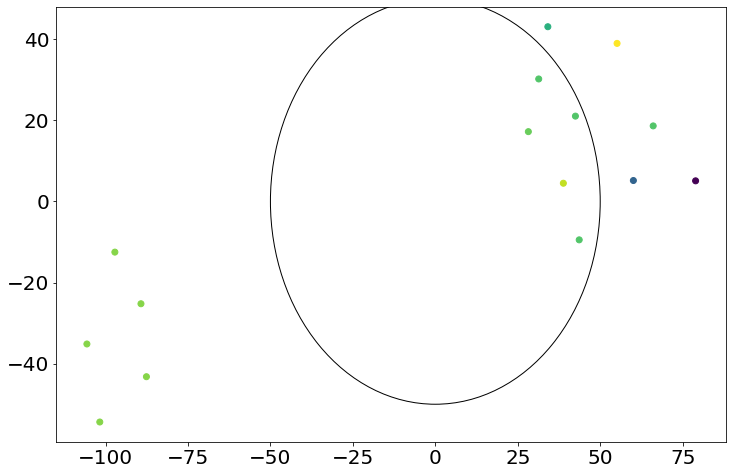

In [8]:
# fig,ax = plt.subplots()
plt.scatter(stations_local[:,0]/1000., stations_local[:,1]/1000., c=aves[:,3])
# plt.colorbar()

circle=plt.Circle((0,0),50,color='k',fill=False)
# plt.xlim(-80,80)
# plt.ylim(-80,80)
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.show()

### Setting up grid

Input desired grid boundaries and interval here in meters from the center of the network (no point located over the center!)

In [9]:
xmin, xmax, xint = -200001, 199999, 5000
ymin, ymax, yint = -200001, 199999, 5000
# alts = np.arange(500,20500,500.)
alts = np.array([7000])

initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(ymin,ymax+yint,yint), alts))

In [10]:
x,y,z=initial_points.reshape((3,int(np.size(initial_points)/3)))
points2 = tanp.toLocal(np.array(projl.toECEF(x,y,z))).T

means = np.empty(np.shape(points2))
stds  = np.empty(np.shape(points2))
misses= np.empty(np.shape(points2))

In [11]:
tanp_all = []
for i in range(len(aves[:,0])): 
    tanp_all = tanp_all + [TangentPlaneCartesianSystem(aves[i,1],aves[i,2],aves[i,0])]

### General calculations at grid points
Set number of iterations and solution requirements here

Note that if any source is not retreived at enough stations for a solution, a RuntimeWarning will be raised by the following fuction but this should not impact the final solutions. 

In [ ]:
%%time

iterations=100

# # for r,theta,z errors and standard deviations and overall detection efficiency
for i in range(len(x)):
    means[i], stds[i], misses[i] = sf.black_box(points2[i,0], points2[i,1], points2[i,2], 
             iterations,
             stations_local,
             ordered_threshs,
             stations_ecef,center_ecef,tanp_all, c0,dt_rms,tanp,projl,
             chi2_filter=5.,
             min_stations=6,
             just_rms=False
             )

In [25]:
iterations=100
rms = np.empty(np.shape(points2))

# Just rmse values:
for i in range(len(x)):
    rms[i] = sf.black_box(x[i], y[i], z[i], iterations,
             stations_local,ordered_threshs,stations_ecef,center_ecef,
             tanp_all,c0,dt_rms,tanp,projl,
             chi2_filter=5.,min_stations=6,just_rms=True
             )

In [14]:
means  = (means.T.reshape(np.shape(initial_points)))
stds   = (stds.T.reshape(np.shape(initial_points)))
misses = (misses.T.reshape(np.shape(initial_points)))
# rms    = (rms.T.reshape(np.shape(initial_points)))

means  = np.ma.masked_where(np.isnan(means) , means)
stds   = np.ma.masked_where(np.isnan(stds)  , stds)
misses = np.ma.masked_where(np.isnan(misses), misses)
rms    = np.ma.masked_where(np.isnan(rms), rms)

### Average error plots

#### RMS Error plots of errors in (x, y, z) coordinates

In [12]:
# means = np.load('means_7km_MC.dat',allow_pickle=True)
# stds = np.load('stds_7km_MC.dat',allow_pickle=True)
# misses = np.load('misses_7km_MC.dat',allow_pickle=True)
# rms = np.load('rms_7km_MC.dat',allow_pickle=True)

means = np.load('means_full_grid.dat',allow_pickle=True)
stds = np.load('stds_full_grid.dat',allow_pickle=True)
misses = np.load('misses_full_grid.dat',allow_pickle=True)
rms = np.load('rms_full_grid.dat',allow_pickle=True)

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [14]:
def mapped_plot(data,vmin,vmax,cmap,stations,
                xmin,xmax,xint,ymin,ymax,yint,location):
    
    """Make plots in map projection with km color scales, requires input 
       array, lower color scale limit, higher color scale limit, color scale, 
       station location overlay, and array x-,y- min, max and interval, the 
       location of the array center (in lat and lon). Output plot also 
       contains 100, 200 km range rings
    """
    import cartopy.crs as ccrs
    
    domain = (xmax-xint/2.)
    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=location[1], central_latitude=location[0])

    plt.figure(figsize=(18,10))
    
    ax = plt.axes(projection=proj)
    s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
               np.arange(ymin-yint/2.,ymax+3*yint/2.,yint)+domain,
               data,cmap = cmap,transform=proj)
    
    s.set_clim(vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.scatter(stations[:,0]+domain, stations[:,1]+domain, color='k')

    circle=plt.Circle((domain,domain),100000,color='k',fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle)
    circle=plt.Circle((domain,domain),200000,color='k',fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle)
                
    states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
    lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='110m',
        facecolor='none')
    ax.add_feature(lakes, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
    ax.coastlines()

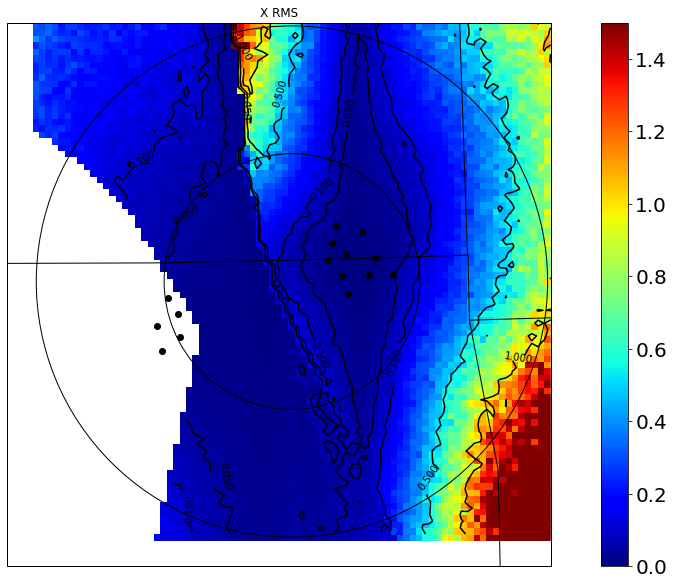

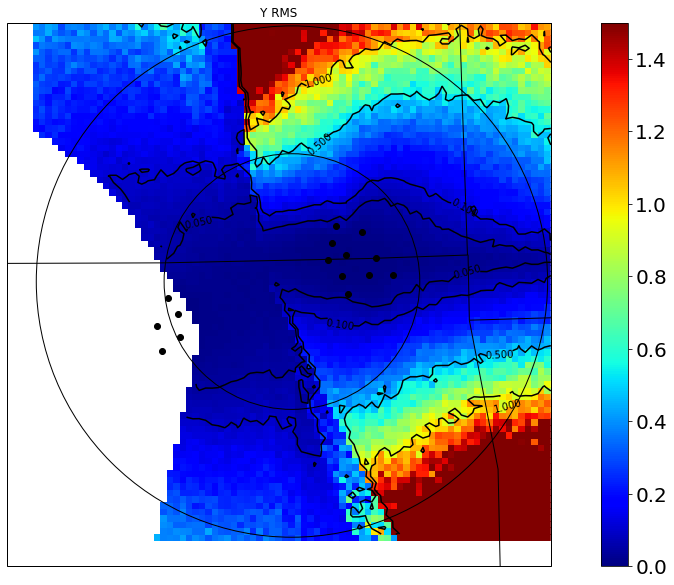

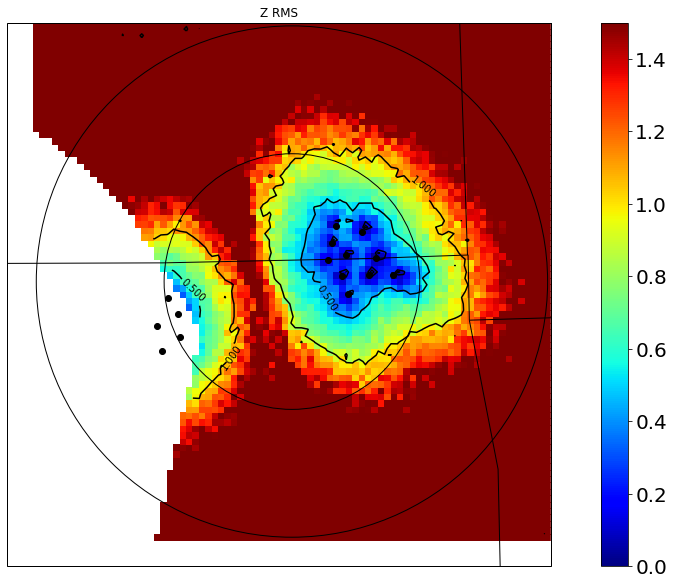

In [15]:
# X-RMS
mapped_plot(rms[0,:,:,0]/1000.,0,1.5,'jet',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+xmax,
                 np.arange(ymin,ymax+yint,yint)+ymax,
                 rms[0,:,:,0]/1000., colors='k',levels=(0.05,0.1,0.5,1,5))
plt.clabel(CS, inline=1, fontsize=10)
plt.title('X RMS')
plt.show()

# Y-RMS
mapped_plot(rms[1,:,:,0]/1000.,0,1.5,'jet',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+xmax,
                 np.arange(ymin,ymax+yint,yint)+ymax,
                 rms[1,:,:,0]/1000., colors='k',levels=(0.05,0.1,0.5,1,5))
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Y RMS')
plt.show()

# Z-RMS
mapped_plot(rms[2,:,:,0]/1000.,0,1.5,'jet',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+xmax,
                 np.arange(ymin,ymax+yint,yint)+ymax,
                 rms[2,:,:,0]/1000., colors='k',levels=(0.05,0.1,0.5,1,5))
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Z RMS')
plt.show()


### Standard Errors in (r, theta, z) coordinates
#### Mean Range Error

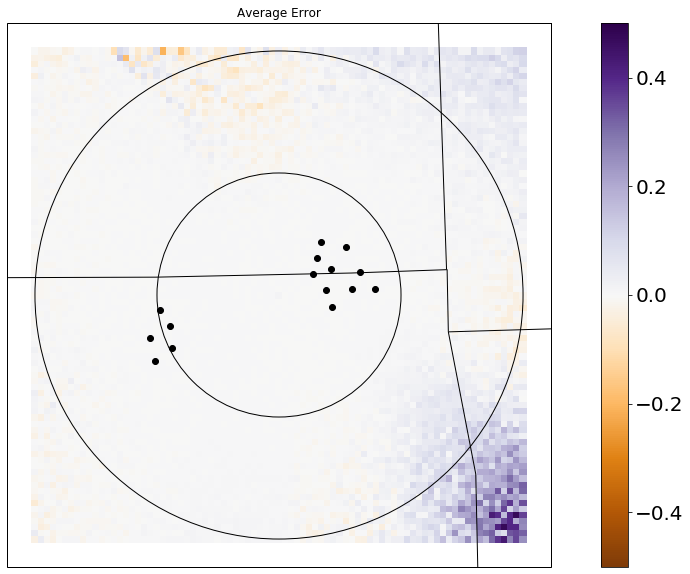

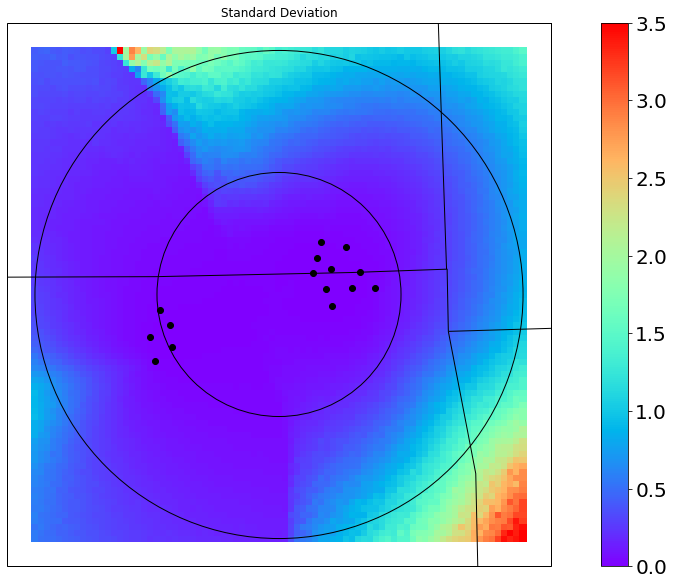

In [16]:
mapped_plot(np.mean(means[0,:,:,:],axis=2)/1000.,-0.5,0.5,'PuOr',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Average Error')
plt.show()

mapped_plot(np.mean(stds[0,:,:,:],axis=2)/1000.,0,3.5,'rainbow',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Standard Deviation')
plt.show()

#### Mean Altitude Error

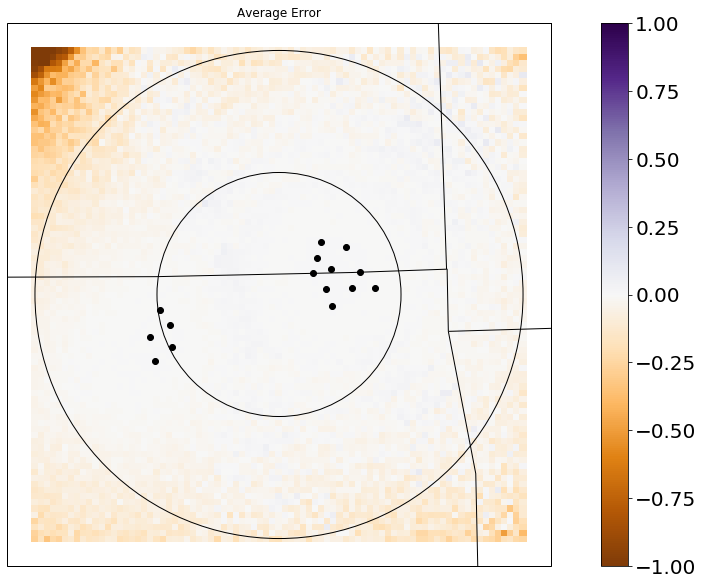

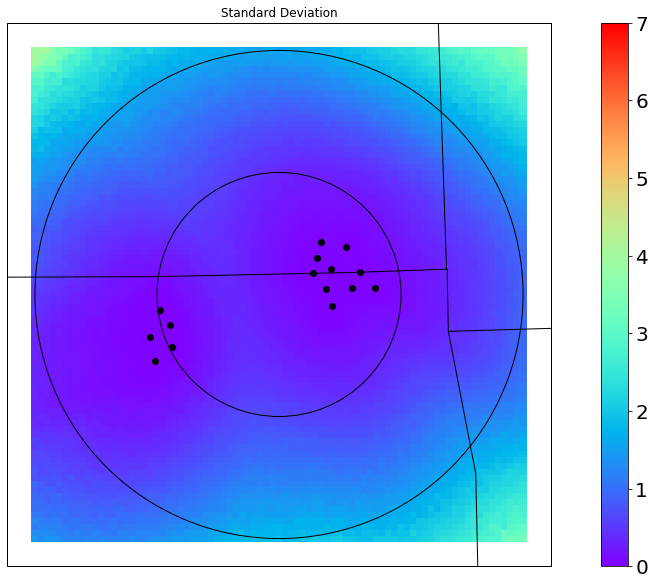

In [51]:
mapped_plot(np.mean(means[2,:,:,:],axis=2)/1000.,-1,1,'PuOr',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Average Error')
plt.show()

mapped_plot(np.mean(stds[2,:,:,:],axis=2)/1000.,0,7,'rainbow',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Standard Deviation')
plt.show()

#### Mean Azimuth Error

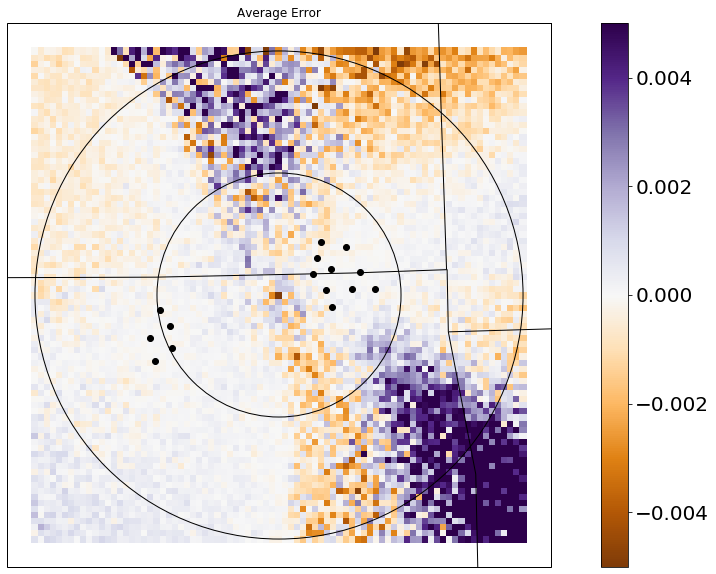

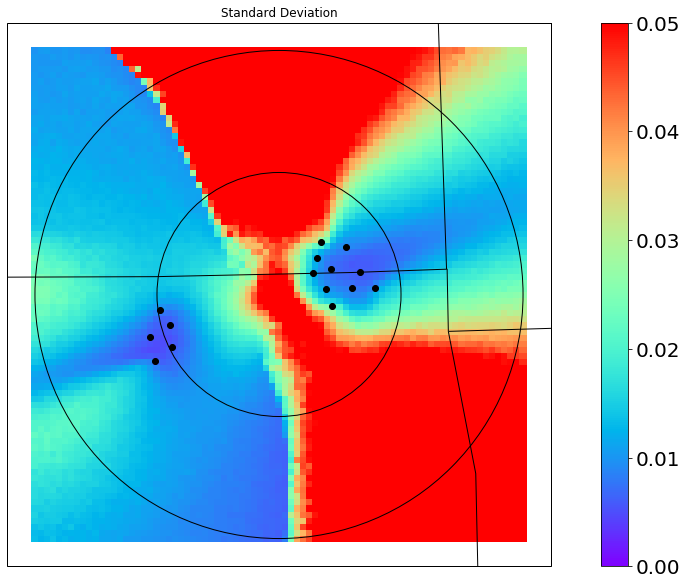

In [52]:
mapped_plot(np.mean(means[1,:,:,:],axis=2),-0.005,0.005,'PuOr',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Average Error')
plt.show()

mapped_plot(np.mean(stds[1,:,:,:],axis=2),0,0.05,'rainbow',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Standard Deviation')
plt.show()

### Detection efficiency

In [53]:
iterations=100 # Set if reading in from a file

In [54]:
xs  = 1000./np.arange(10,1000,1.) # Theoretical source detection efficiency that corresponds with fde
fde = 100-np.load('../../../LMAsimulation/fde.csv',fix_imports=True, encoding='latin1',allow_pickle=True) # Corresponding flash DE
sde = 100-np.mean(misses[0,:,:,:], axis=2)*100./iterations # Calculated source detection efficiency
fde_a = np.empty_like(sde)

selects = sde == 100. # Put into the next lowest or equivalent flash DE from given source DE
fde_a[selects] = 100.
for i in range(len(xs)-1):
    selects = (sde >= xs[1+i]) & (sde < xs[i])
    fde_a[selects] = fde[i]

# Find center of 95% SOURCE detection efficiency
goods = (100-np.mean(misses[0,:,:,:], axis=2)*100./iterations)>95. 
de_centery = np.mean(initial_points[1,:,:,0][goods])
de_centerx = np.mean(initial_points[0,:,:,0][goods])
print ("DE center location in km: ", de_centerx/1000., ", ", de_centery/1000.)

DE center location in km:  45.75973619631902 ,  16.21985889570552


/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


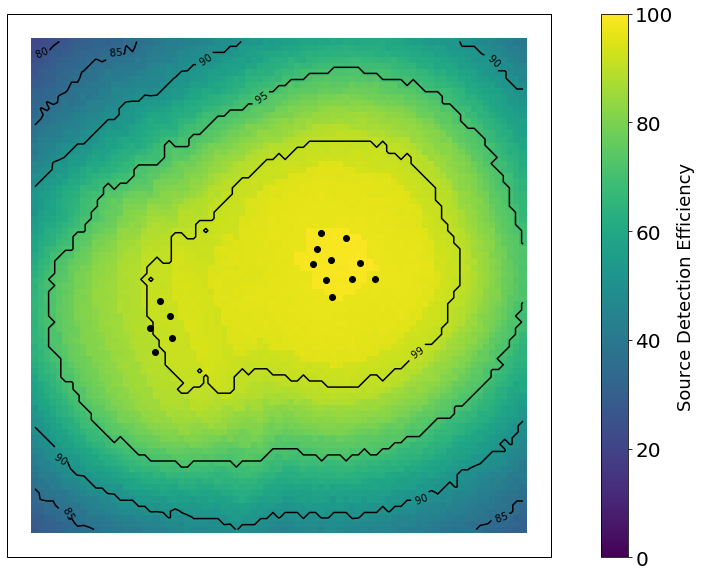

In [55]:
domain = 197.5*1000 # Relates back to domain size (xmax - xint/2) to shift map
# maps = Basemap(projection='laea', lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=center[1], central_latitude=center[0])

plt.figure(figsize=(18,10))
ax = plt.axes(projection=proj)

s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(ymin-yint/2.,ymax+3*yint/2.,yint)+domain,
                   100-np.mean(misses[0,:,:,:], axis=2)*100./iterations,
                  cmap = 'viridis',transform=proj)
s.set_clim(vmin=0,vmax=100)
plt.colorbar(label='Source Detection Efficiency')
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+domain,
                   np.arange(ymin,ymax+yint,yint)+domain,
                   fde_a, colors='k',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k')
# plt.scatter(np.array([de_centerx+domain]), np.array([de_centery+domain]), color='r')

# maps.drawstates()
plt.tight_layout()
plt.show()

### Flash Distortion

In [23]:
# # Full Levels
# sigmar = np.mean(stds[0,:,:,9:30],axis=2)
# sigmaa = np.mean(stds[1,:,:,9:30],axis=2)
# sde = 100-np.mean(misses[0,:,:,9:30], axis=2)*100./iterations # Calculated source detection efficiency

# One Level
sigmar = (stds[0,:,:,0])
sigmaa = (stds[1,:,:,0])
sde    = (1-misses[0,:,:,0]/iterations)*100

xf = np.arange(xmin,xmax+xint,xint)/1000.
yf = np.arange(ymin,ymax+yint,yint)/1000.
xy = np.meshgrid(xf,yf)
ranges = (xy[0]**2+xy[1]**2)**0.5*1000.

fl_areas,fl_numbers = np.load('typical_flashes.csv',fix_imports=True, encoding='latin1')

FileNotFoundError: [Errno 2] No such file or directory: 'typical_flashes.csv'

In [57]:
areas = np.empty_like(sde)
numbers = np.empty_like(sde)

selects = sde == 100. # Put into the next lowest or equivalent flash DE from given source DE
areas[selects] = fl_areas[0]
numbers[selects] = fl_numbers[0]
for i in range(len(xs)-1):
    selects = (sde >= xs[1+i]) & (sde < xs[i])
    areas[selects] = fl_areas[i]
    numbers[selects] = fl_numbers[i]

NameError: name 'fl_areas' is not defined

In [58]:
domain = (xmax-xint/2.)
maps = Basemap(projection='laea',lat_0=center[0],lon_0=center[1],width=domain*2,height=domain*2)
s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(ymin-yint/2.,ymax+3*yint/2.,yint)+domain,
                   (areas), cmap = 'viridis_r')
s.set_clim(vmin=18,vmax=50)
plt.colorbar()
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k', s=0.5)
maps.drawstates()
circle=plt.Circle((domain,domain),100000,color='k',fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle)
circle=plt.Circle((domain,domain),200000,color='k',fill=False)
fig.gca().add_artist(circle)
plt.title('Typical Flash area')

plt.tight_layout()
plt.show()

NameError: name 'Basemap' is not defined

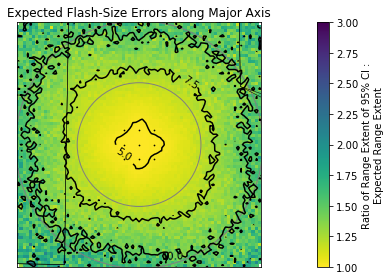

In [41]:
major_axis_est = norm.ppf(0.975**(1./(numbers*sde/100.)))*sigmar*2+2000*(areas/np.pi)**0.5

domain = (xmax-xint/2.)
maps = Basemap(projection='laea',lat_0=center[0],lon_0=center[1],width=domain*2,height=domain*2)
s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(ymin-yint/2.,ymax+3*yint/2.,yint)+domain,
                   (major_axis_est)/(2000*(areas/np.pi)**0.5), cmap = 'viridis_r')
plt.colorbar(label='Ratio of Range Extent of 95% CI :\nExpected Range Extent')
plt.clim(1,3)
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+domain,
                 np.arange(ymin,ymax+yint,yint)+domain,
                 major_axis_est/1000., colors='k',levels=(5,7.5,10,15,20)) 
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.1f')
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k', s=0.5)
maps.drawstates()
circle=plt.Circle((domain,domain),100000,color='0.5',fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle)
circle=plt.Circle((domain,domain),200000,color='0.5',fill=False)
fig.gca().add_artist(circle)
plt.title('Expected Flash-Size Errors along Major Axis')

plt.tight_layout()
plt.show()

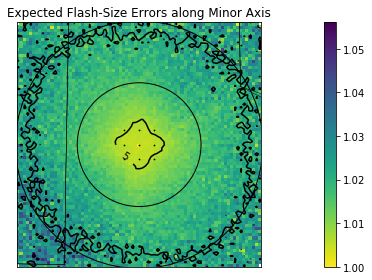

In [42]:
minor_axis_est = 2.*ranges*np.tan(np.deg2rad(norm.ppf(0.975**(1./(numbers*sde/100.)))*sigmaa))+2000*(areas/np.pi)**0.5

domain = (xmax-xint/2.)
maps = Basemap(projection='laea',lat_0=center[0],lon_0=center[1],width=domain*2,height=domain*2)
s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(ymin-yint/2.,ymax+3*yint/2.,yint)+domain,
                   (minor_axis_est)/(2000*(areas/np.pi)**0.5), cmap = 'viridis_r')
plt.colorbar()
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+domain,
                 np.arange(ymin,ymax+yint,yint)+domain,
                 major_axis_est/1000., colors='k',levels=(5,10,15,20))
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k', s=0.5)
maps.drawstates()
circle=plt.Circle((domain,domain),100000,color='k',fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle)
circle=plt.Circle((domain,domain),200000,color='k',fill=False)
fig.gca().add_artist(circle)
plt.title('Expected Flash-Size Errors along Minor Axis')

plt.tight_layout()
plt.show()

### Plotting radial average in the map projection

Must have multiple altitudes

In [ ]:
rs = np.arange(0,200000+xint,xint)
radial_ave = np.empty((len(rs)-1,3,len(alts)))

for i in range(len(rs)-1):
    selects = ((initial_points[0,:,:,0]**2+initial_points[1,:,:,0]**2)**0.5>rs[i]
              ) & ((initial_points[0,:,:,0]**2+initial_points[1,:,:,0]**2)**0.5<=rs[i+1])
    radial_ave[i] = np.mean(means[:,selects,:],axis=1)

rs_ecef = tanp.fromLocal(np.vstack((rs, np.zeros_like(rs), np.zeros_like(rs))))

In [ ]:
s = plt.pcolormesh(rs/1000.,
                   np.hstack((alts-250.,np.max(alts)+250.))/1000.,
                   radial_ave[:,2,:].T/1000.)
plt.plot(rs/1000.,projl.fromECEF(rs_ecef[0], rs_ecef[1], rs_ecef[2])[2]/1000., color='0.8')
plt.clim(vmin=-0.25,vmax=2.5)
plt.ylim(0.25,20)
plt.xlabel('Range')
plt.ylabel('Altitude')
plt.colorbar(label='Average Altitude Error (km)')
plt.colorbar()
plt.tight_layout()
plt.show()

### Plotting radial average in the local tangent plane

In [ ]:
zs = np.arange(-6000,20000,1000)
radial_ave2 = np.empty((len(rs)-1,3,len(zs)))

for i in range(len(rs)-1):
    for j in range(len(zs)-1):
        selects = (((points2[:,1]**2+points2[:,0]**2)**0.5>rs[i]) & 
                   ((points2[:,1]**2+points2[:,0]**2)**0.5<=rs[i+1]) &
                   ((points2[:,2])>zs[j]) & ((points2[:,2]<=zs[j+1])))
        radial_ave2[i,:,j] = np.mean(means[:,selects.T.reshape(np.shape(initial_points[0]))],axis=1)

In [ ]:
s = plt.pcolormesh(rs/1000.,
                   zs/1000.,
                   radial_ave2[:,2,:].T/1000.)
plt.clim(vmin=-0.25,vmax=2.5)
plt.xlabel('Radial Distance (km)')
plt.ylabel('Height (km)')
plt.colorbar(label='Average Altitude Error (km)')
plt.show()

### Reading/writing the arrays from/to a file

In [ ]:
case_name = 'WTLMA_ave_6_1000'

In [ ]:
# misses.dump('cases/%s/error_misses.csv' %(case_name))
# stds.dump(  'cases/%s/error_stds.csv'   %(case_name))
# means.dump( 'cases/%s/error_means.csv'  %(case_name))

In [ ]:
stds   = np.load('cases/%s/error_stds.csv'   %(case_name),fix_imports=True, encoding='latin1')
means  = np.load('cases/%s/error_means.csv'  %(case_name),fix_imports=True, encoding='latin1')
misses = np.load('cases/%s/error_misses.csv' %(case_name),fix_imports=True, encoding='latin1')